In [1]:
from osgeo import gdal, ogr
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans


In [4]:
#set path to image
path="mask_spam2017V2r1_SSA_A_COCO_A.tif"
path2="spam2017V2r1_SSA_A_COCO_A.tif"


Define Fuction for Reprojection and Conversion

In [25]:
def read_transform(path, EPSGCODE):
    output="Temp.tif"
    Transform = gdal.Warp(output, path, dstSRS=EPSGCODE)
    To_Array = Transform.ReadAsArray()

    return Transform, To_Array
    

In [26]:
EPSGCODE = 'EPSG:3857'

In [27]:
GDAL, Array =read_transform(path, EPSGCODE)

In [29]:
GDAL

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fe722837810> >

In [30]:
Array

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

Test if it Works!

In [31]:
test_crs = GDAL.GetProjection()
test_crs

'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'

Plot

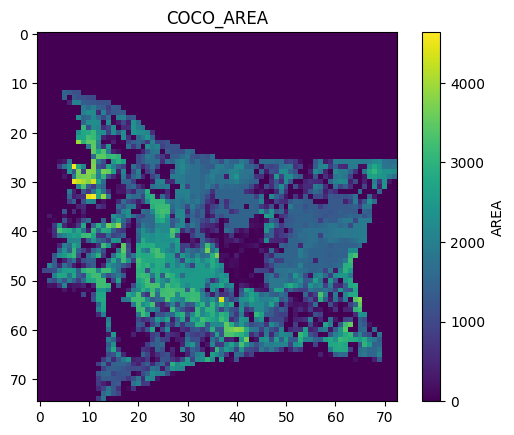

In [34]:
# Plot the raster data using matplotlib
plt.imshow(Array, cmap='viridis')
plt.title('COCO_AREA')
plt.colorbar(label='AREA')
plt.show()


GDAL To Rasterio Conversion !

In [16]:
def gdal_to_rasterio(gdal_ds):
    
    # Read the data and metadata
    data = gdal_ds.ReadAsArray()
    geo_transform = gdal_ds.GetGeoTransform()
    projection = gdal_ds.GetProjection()

    # Get the dimensions of the raster
    cols = gdal_ds.RasterXSize
    rows = gdal_ds.RasterYSize

    # Calculate the affine transformation matrix for rasterio
    transform = rasterio.transform.from_origin(geo_transform[0], geo_transform[3], geo_transform[1], geo_transform[5])

    # Create the rasterio dataset in memory
    memfile = MemoryFile()
    with memfile.open(driver='GTiff', width=cols, height=rows, count=1,
                      dtype=data.dtype, crs=projection,
                      transform=transform) as dst:
        dst.write(data, 1)

    # Close the GDAL dataset
    gdal_ds = None
    
    # Return the rasterio dataset
    return memfile.open()

In [19]:

rasterio_ds = gdal_to_rasterio(test)


In [20]:
rasterio_ds

<open DatasetReader name='/vsimem/54297bf6-02c0-4501-bd0d-a2eca505783e/54297bf6-02c0-4501-bd0d-a2eca505783e.tif' mode='r'>

Check it again

In [32]:
def get_raster_specs(src):
    specs = {
        'crs': src.crs,
        'extent': src.bounds,
        'pixel_size': src.res,
        'width': src.width,
        'height': src.height,
        'count': src.count,
        "Driver:": src.driver,
        "Mode:": src.mode,
        "Is closed?": src.closed,
        "Data types:": src.dtypes,
        "Transform:": src.transform,
        "Block shapes:": src.block_shapes,
        "Nodata values:": src.nodata,
        "Indexes:": src.indexes,
        "Descriptions:": src.descriptions,
        "Tags:": src.tags(),
        "Color interpretation:": src.colorinterp,
        "CRS:": src.crs,
        #"CRS WKT:": src.crs_wkt,
        #"CRS Proj4:": src.crs_proj,
        "Transform:": src.transform
    }
    return specs

def get_proj(src):
    specs = {
        'crs': src.crs,
    }
    return specs

In [33]:
raster_specs = get_raster_specs(rasterio_ds)
print(raster_specs)

{'crs': CRS.from_epsg(3857), 'extent': BoundingBox(left=-955568.6240397836, bottom=1893417.1629097178, right=-275155.7938140526, top=1194362.885280542), 'pixel_size': (9320.723701722343, 9320.723701722343), 'width': 73, 'height': 75, 'count': 1, 'Driver:': 'GTiff', 'Mode:': 'r', 'Is closed?': False, 'Data types:': ('float32',), 'Transform:': Affine(9320.723701722343, 0.0, -955568.6240397836,
       0.0, 9320.723701722343, 1194362.885280542), 'Block shapes:': [(28, 73)], 'Nodata values:': None, 'Indexes:': (1,), 'Descriptions:': (None,), 'Tags:': {'AREA_OR_POINT': 'Area'}, 'Color interpretation:': (<ColorInterp.gray: 1>,), 'CRS:': CRS.from_epsg(3857)}
